# Preprocessing

### 1. Load data

In [1]:
import numpy as np

#open data from npy file
data = np.load("trainingData.npy")
# data comes in shape (data_points, field_width, field_height, channels) reshape it to (data_points, channels, field_width, field_height)
data = np.transpose(data, (0, 3, 1, 2))
print(f"Loaded data shape: {data.shape}")
print("Shape format: (data_points, channels, field_width, field_height)")

Loaded data shape: (101, 2, 21, 21)
Shape format: (data_points, channels, field_width, field_height)


### 2. Visualise the data

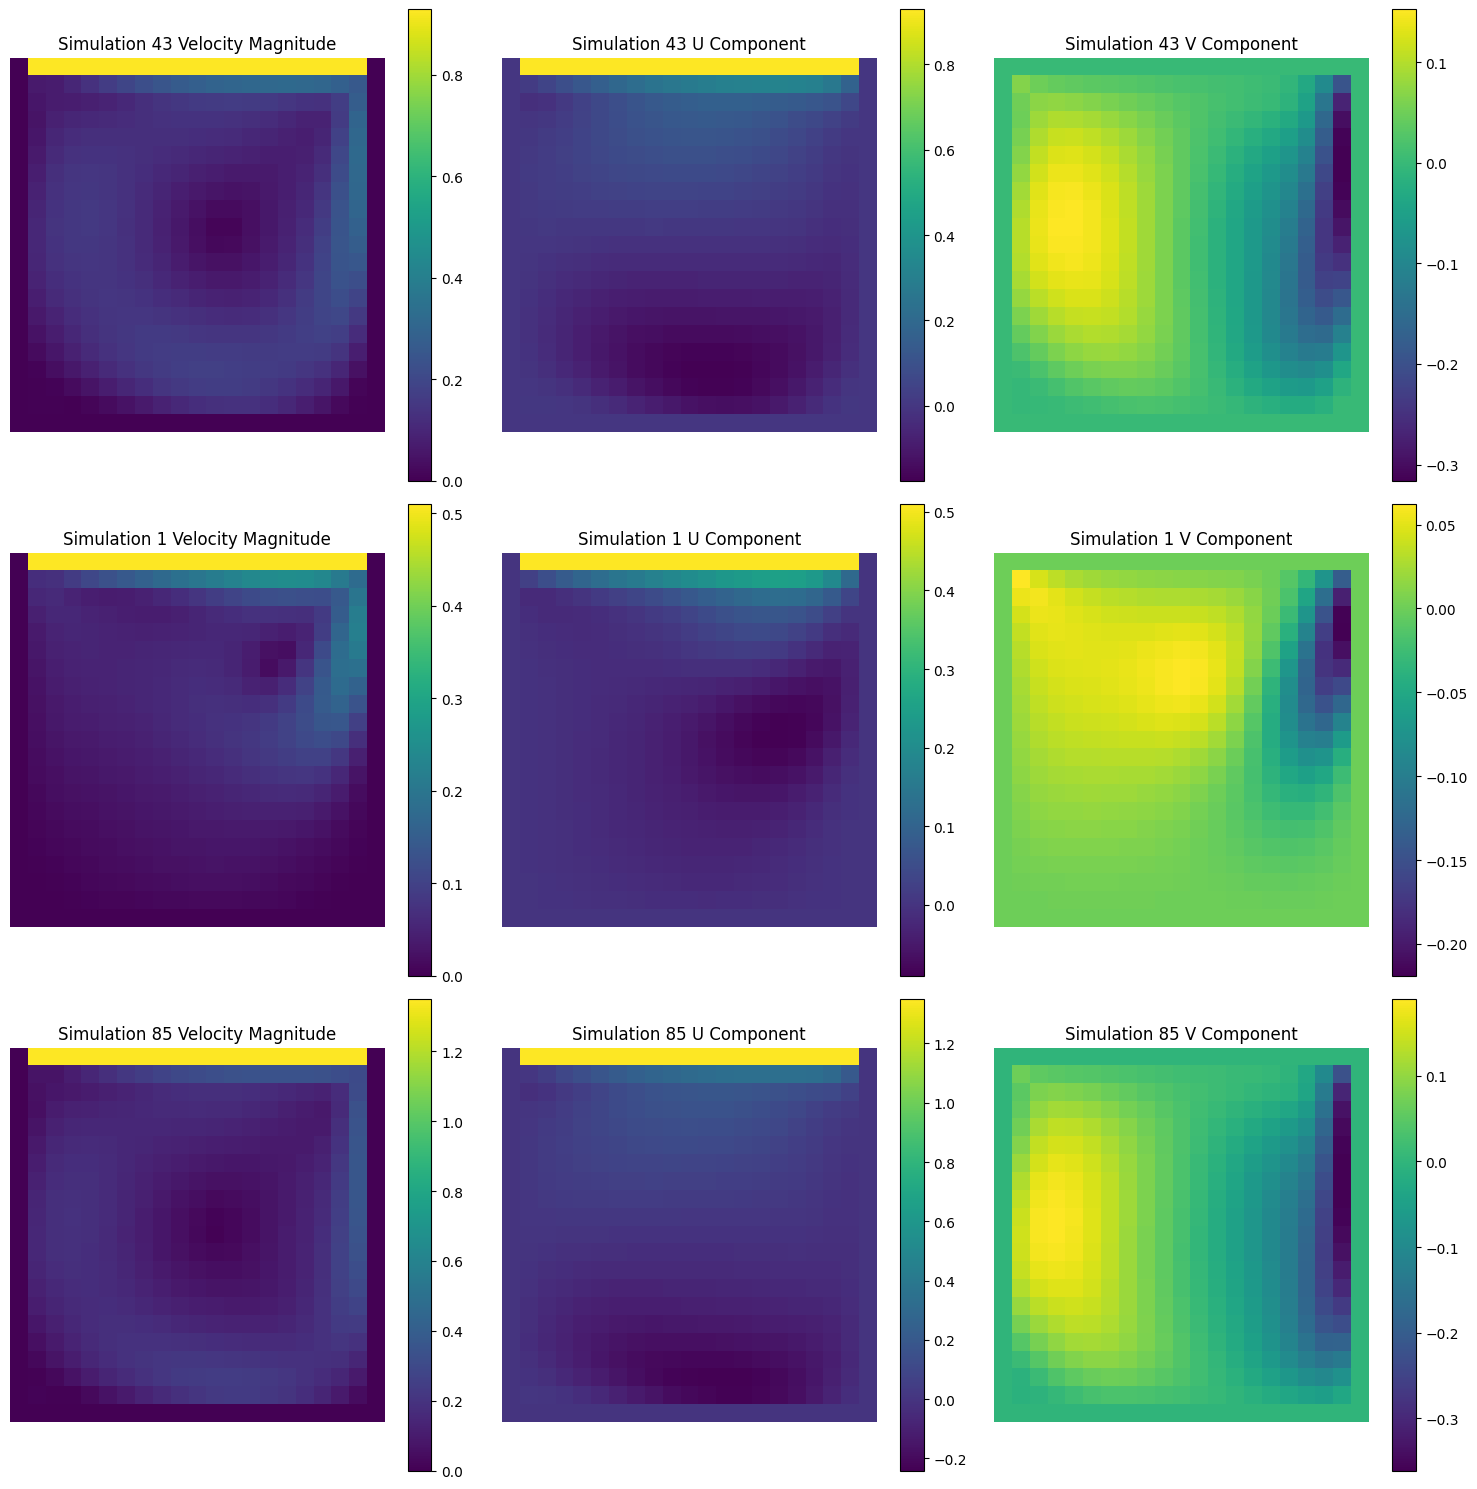

In [2]:
import matplotlib.pyplot as plt

# Select a few random simulations to visualize
num_samples = 3
random_indices = np.random.choice(data.shape[0], num_samples, replace=False)
fig, axes = plt.subplots(3, num_samples, figsize=(5 * 3, 5 * num_samples))
axes = axes.flatten()
for i, idx in enumerate(random_indices):
    uv_field = data[idx]
    u = uv_field[0, :, :]
    v = uv_field[1, :, :]
    
    magnitude = np.sqrt(u**2 + v**2)
    
    ax = axes[i*3]
    im = ax.imshow(magnitude, cmap='viridis', origin='lower')
    ax.set_title(f'Simulation {idx} Velocity Magnitude')
    ax.axis('off')
    fig.colorbar(im, ax=ax)

    ax = axes[i*3 + 1]
    im = ax.imshow(u, cmap="viridis", origin='lower')
    ax.set_title(f'Simulation {idx} U Component')
    ax.axis('off')
    fig.colorbar(im, ax=ax)

    ax = axes[i*3 + 2]
    im = ax.imshow(v, cmap='viridis', origin='lower')
    ax.set_title(f'Simulation {idx} V Component')
    ax.axis('off')
    fig.colorbar(im, ax=ax)
plt.tight_layout()

### 3. preprocess the data

In [3]:
# scale u and v to range [0,1]
u_min = data[:,0,:,:].min()
u_max = data[:,0,:,:].max()
v_min = data[:,1,:,:].min()
v_max = data[:,1,:,:].max()
print(f"U component original range: [{u_min}, {u_max}]")
print(f"V component original range: [{v_min}, {v_max}]")

# scale:
data_scaled = np.empty_like(data)
data_scaled[:,0,:,:] = (data[:,0,:,:] - u_min) / (u_max - u_min)
data_scaled[:,1,:,:] = (data[:,1,:,:] - v_min) / (v_max - v_min)

print(f"U component scaled to range: [{data_scaled[:,0,:,:].min()}, {data_scaled[:,0,:,:].max()}]")
print(f"V component scaled to range: [{data_scaled[:,1,:,:].min()}, {data_scaled[:,1,:,:].max()}]")

U component original range: [-0.2558729992406598, 1.5000002991077972]
V component original range: [-0.37222149873786936, 0.20091780681300947]
U component scaled to range: [0.0, 1.0]
V component scaled to range: [0.0, 1.0]


### Generate input data

Input data shape: (101, 21, 21)


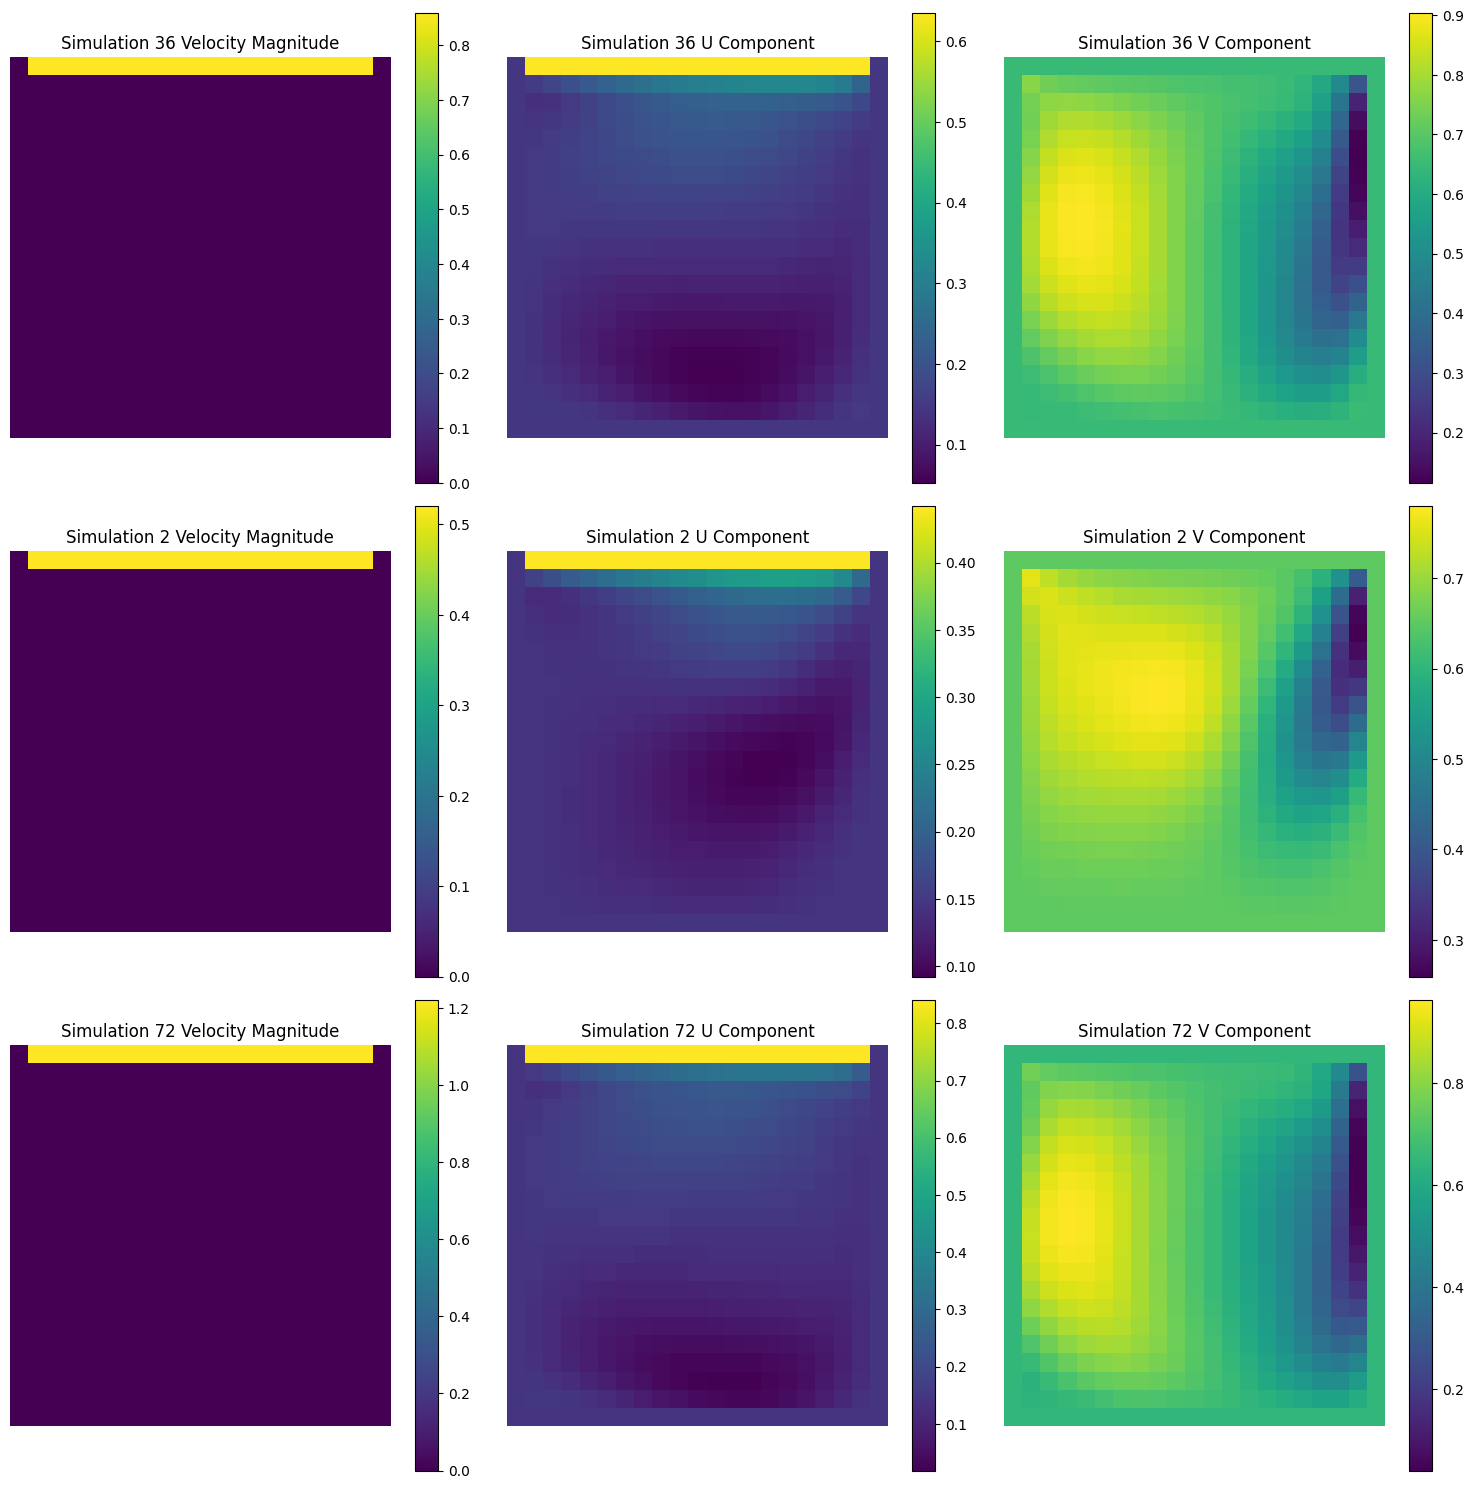

In [4]:
input = np.zeros_like(data_scaled[:,0,:,:])
print(f"Input data shape: {input.shape}")

velocities = np.linspace(0.5, 1.5, num=input.shape[0])
for i in range(data_scaled.shape[0]):
    n = data_scaled.shape[2]
    input[i,n-1,1:n-1] = velocities[i]

num_samples = 3
random_indices = np.random.choice(data_scaled.shape[0], num_samples, replace=False)
fig, axes = plt.subplots(3, num_samples, figsize=(5 * 3, 5 * num_samples))
axes = axes.flatten()
for i, idx in enumerate(random_indices):
    uv_field = data_scaled[idx]
    u = uv_field[0, :, :]
    v = uv_field[1, :, :]
    
    magnitude = input[idx]
    
    ax = axes[i*3]
    im = ax.imshow(magnitude, cmap='viridis', origin='lower')
    ax.set_title(f'Simulation {idx} Velocity Magnitude')
    ax.axis('off')
    fig.colorbar(im, ax=ax)

    ax = axes[i*3 + 1]
    im = ax.imshow(u, cmap="viridis", origin='lower')
    ax.set_title(f'Simulation {idx} U Component')
    ax.axis('off')
    fig.colorbar(im, ax=ax)

    ax = axes[i*3 + 2]
    im = ax.imshow(v, cmap='viridis', origin='lower')
    ax.set_title(f'Simulation {idx} V Component')
    ax.axis('off')
    fig.colorbar(im, ax=ax)
plt.tight_layout()

### rescale input data

In [5]:
# scale input to [0,1]
input_min = input.min()
input_max = input.max()
input_scaled = np.empty_like(input)
input_scaled = (input - input_min) / (input_max - input_min)

print(f"Input data scaled to range: [{input_scaled.min()}, {input_scaled.max()}]")

Input data scaled to range: [0.0, 1.0]


### Make yaml

In [6]:
import yaml

# Create the min_max dictionary with the normalization parameters
min_max = {
    'inputs': {
        'u': {
            'max': float(input_max),
            'min': float(input_min)
        }
    },
    'labels': {
        'u': {
            'max': float(u_max),
            'min': float(u_min)
        },
        'v': {
            'max': float(v_max),
            'min': float(v_min)
        }
    }
}

# Save to yaml file
with open('min_max.yaml', 'w') as f:
    yaml.dump(min_max, f, default_flow_style=False)

print("min_max.yaml file created successfully!")
print("\nContents:")
print(yaml.dump(min_max, default_flow_style=False))

min_max.yaml file created successfully!

Contents:
inputs:
  u:
    max: 1.5
    min: 0.0
labels:
  u:
    max: 1.5000002991077972
    min: -0.2558729992406598
  v:
    max: 0.20091780681300947
    min: -0.37222149873786936



## Train Test Validation Split

In [8]:
from sklearn.model_selection import train_test_split

# First split: separate out test set (10%)
train_val_input, test_input, train_val_labels, test_labels = train_test_split(
    input_scaled, data_scaled, test_size=0.1, random_state=42, shuffle=True
)

# Second split: separate training (80%) and validation (10%) from the remaining 90%
train_input, val_input, train_labels, val_labels = train_test_split(
    train_val_input, train_val_labels, test_size=0.1111, random_state=42, shuffle=True
)

print(f"Training set: {train_input.shape[0]} samples ({train_input.shape[0]/input_scaled.shape[0]*100:.1f}%)")
print(f"Validation set: {val_input.shape[0]} samples ({val_input.shape[0]/input_scaled.shape[0]*100:.1f}%)")
print(f"Test set: {test_input.shape[0]} samples ({test_input.shape[0]/input_scaled.shape[0]*100:.1f}%)")
print(f"\nInput shape: {train_input.shape}")
print(f"Labels shape: {train_labels.shape}")

# Save the datasets
np.save('train_input.npy', train_input)
np.save('train_labels.npy', train_labels)
np.save('val_input.npy', val_input)
np.save('val_labels.npy', val_labels)
np.save('test_input.npy', test_input)
np.save('test_labels.npy', test_labels)

Training set: 80 samples (79.2%)
Validation set: 10 samples (9.9%)
Test set: 11 samples (10.9%)

Input shape: (80, 21, 21)
Labels shape: (80, 2, 21, 21)
